In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

In [5]:
   
toload = [
    dict(name="fixfloorbase", id = "xph14-newalldisabled_lofloors"),
    dict(name="addrec", id = "xph14a-add_rec"),
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(
        case["id"], use_squash = False, verbose = True, 
        # force_squash = force,
        use_xhermes = True)

- Reading case xph14-newalldisabled_lofloors
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

Unnormalising with xHermes
- Reading case xph14a-add_rec
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

Unnormalising with xHermes


# Pick case

In [7]:
# ds = cs["alldisabled"].ds.isel(t=-1)
# ds = cs["newalldisabled_lopnfloor"].ds.isel(t=-1)
# ds = cs["upwind1stord_lofloor"].ds.isel(t=-1)
ds = cs["upwind1stord_losecondaryfloor"].ds.isel(t=-1)

# Calculate balances

In [8]:
for name in cs:
    ds = cs[name].ds
    #### PARTICLE FLOW
    ds["pfXlo"] = ds["ParticleFlow_d_xlow"]
    ds["pfXhi"] = ds["pfXlo"].shift(x=-1)
    ds["pfYlo"] = ds["ParticleFlow_d_ylow"]
    ds["pfYhi"] = ds["pfYlo"].shift(theta=-1)

    ds["pfXnet"] = ds["pfXlo"] - ds["pfXhi"]
    ds["pfYnet"] = ds["pfYlo"] - ds["pfYhi"]
    ds["pfNet"] = ds["pfXnet"] + ds["pfYnet"]

    ds["pfSrc"] = ds["Sd+_iz"]*ds["dv"]*-1  + ds["Sd_target_recycle"]*ds["dv"]

    if "Sd+_rec" in ds.data_vars:
        ds["pfSrc"] += ds["Sd+_rec"]*ds["dv"]*-1
    if "Sd_wall_recycle" in ds.data_vars:
        ds["pfSrc"] += ds["Sd_wall_recycle"]*ds["dv"]
    if "Sd_src" in ds.data_vars:
        ds["pfSrc"] += ds["Sd_src"]*ds["dv"]


    ds["pfBal"] = ds["pfSrc"] + ds["pfNet"]

    #### ENERGY FLOW
    ds["efXlo"] = ds["EnergyFlow_d_xlow"]
    ds["efXhi"] = ds["efXlo"].shift(x=-1)
    ds["efYlo"] = ds["EnergyFlow_d_ylow"]
    ds["efYhi"] = ds["efYlo"].shift(theta=-1)

    ds["efXnet"] = ds["efXlo"] - ds["efXhi"]
    ds["efYnet"] = ds["efYlo"] - ds["efYhi"]
    ds["efNet"] = ds["efXnet"] + ds["efYnet"]


    ds["efSrc"] = ds["Ed+_iz"]*ds["dv"]*-1  + ds["Ed_target_recycle"]*ds["dv"]

    if "Ed+_rec" in ds.data_vars:
        ds["efSrc"] += ds["Ed+_rec"]*ds["dv"]*-1
    if "Ed_wall_recycle" in ds.data_vars:
        ds["efSrc"] += ds["Ed_wall_recycle"]*ds["dv"]
    if "Ed_target_refl" in ds.data_vars:
        ds["efSrc"] += ds["Ed_target_refl"]*ds["dv"]
    if "Pd_src" in ds.data_vars:
        ds["efSrc"] += ds["Pd_src"]*ds["dv"] * 3/2

    cs[name].ds = ds
# ds["pfSrc"] = ds["Sd+_iz"]*ds["dv"]*-1  + ds["Sd_target_recycle"]*ds["dv"]

# Net flow check

Text(0.5, 1.0, 'OMP')

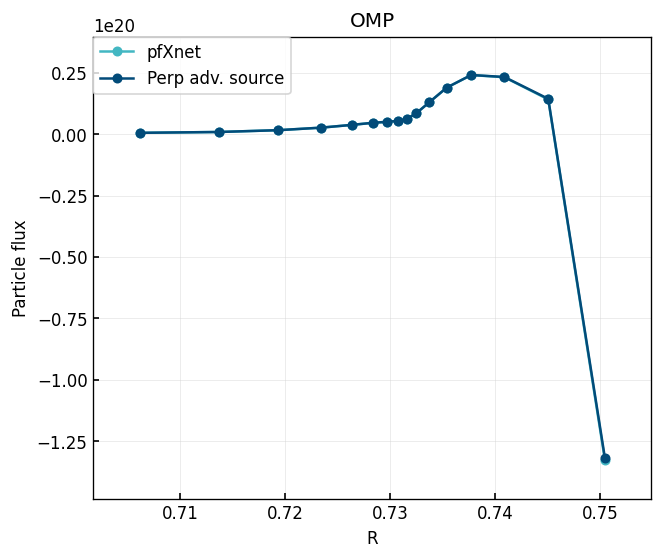

In [27]:
reg = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
title = "OMP"

fig, ax = plt.subplots()

kwargs = dict(marker = "o", ms = 5)
# ax.plot(reg["R"], reg["pfXlo"], label = "pfXlo", **kwargs)
# ax.plot(reg["R"], reg["pfXlo"].shift(x=1), label = "pfXhi", **kwargs)
# ax.plot(reg["R"], reg["pfXlo"].shift(x=1) - reg["pfXlo"], label = "pfXnet A", **kwargs)
# ax.plot(reg["R"], reg["pfXnet"], label = "pfXnet B", **kwargs)
ax.plot(reg["R"], reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(reg["R"], reg["pfYnet"], label = "pfYnet")
# ax.plot(reg["R"], reg["pfNet"], label = "pfNet")
# ax.plot(reg["R"], iz, label = "iz")
# ax.plot(reg["R"], rec, label = "rec")
# ax.plot(reg["R"], pfBal, label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(reg["R"], reg["ddt(Nd)"], label = "ddt(Nd)", c = "k", lw = 4, alpha = 0.5)

ax.plot(reg["R"], reg["Sd_perp_adv"]*reg["dv"], label = "Perp adv. source",  **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)

# Particle balances

## Balance along field line with puffs

Text(0.5, 1.0, 'outer lower field line')

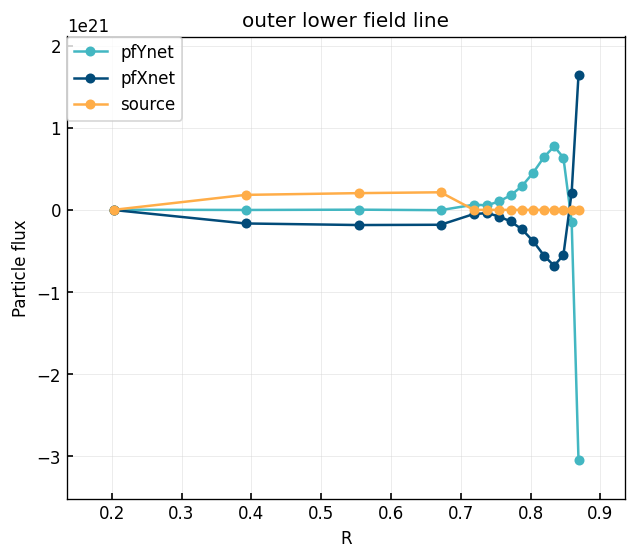

In [55]:
reg = ds.hermesm.select_custom_sol_ring(16, region = "outer_lower").squeeze()
title = "outer lower field line"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)
# ax.plot(x, reg["pfYlo"].values, label = "pfYlo", **kwargs)
# ax.plot(x, reg["pfYlo"].shift(theta=1), label = "pfYhi", **kwargs)
# ax.plot(x, reg["pfYlo"].shift(theta=1) - reg["pfYlo"], label = "pfYnet A", **kwargs)
ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
ax.plot(x, reg["Sd_src"]*reg["dv"], label = "source", **kwargs)
# ax.plot(reg["R"], reg["pfYnet"], label = "pfYnet")
# ax.plot(reg["R"], reg["pfNet"], label = "pfNet")
# ax.plot(reg["R"], iz, label = "iz")
# ax.plot(reg["R"], rec, label = "rec")
# ax.plot(reg["R"], pfBal, label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(reg["R"], reg["ddt(Nd)"], label = "ddt(Nd)", c = "k", lw = 4, alpha = 0.5)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
# ax.set_xlim(0.8, None)

## Single cell balance

In [6]:
reg = ds.hermesm.select_custom_sol_ring(16, region = "outer_lower").squeeze().isel(theta=2)
print(f'FLOWS')
for param in ["pfXlo", "pfXhi", "pfYlo", "pfYhi", "pfXnet", "pfYnet"]:
    print(f'- {param}: {reg[param]:.2e}')
    
print(f'Total net flows: {reg["pfNet"]:.2e}')
    
print(f'\nSOURCES')
totsrc = 0
for param in ["Sd_src", "Sd+_iz"]:
    mult = -1 if "iz" in  param else 1
    src = reg[param]*reg["dv"]*mult #/ (2*np.pi)
    totsrc += src
    print(f'- {param}: {src:.2e}')
    
print(f'Total net sources: {totsrc:.2e}')
    



FLOWS
- pfXlo: -1.83e+20
- pfXhi: -0.00e+00
- pfYlo: -5.24e+17
- pfYhi: -2.61e+18
- pfXnet: -1.83e+20
- pfYnet: 2.09e+18
Total net flows: -1.81e+20

SOURCES
- Sd_src: 2.04e+20
- Sd+_iz: -2.24e+19
Total net sources: 1.81e+20


## OMP

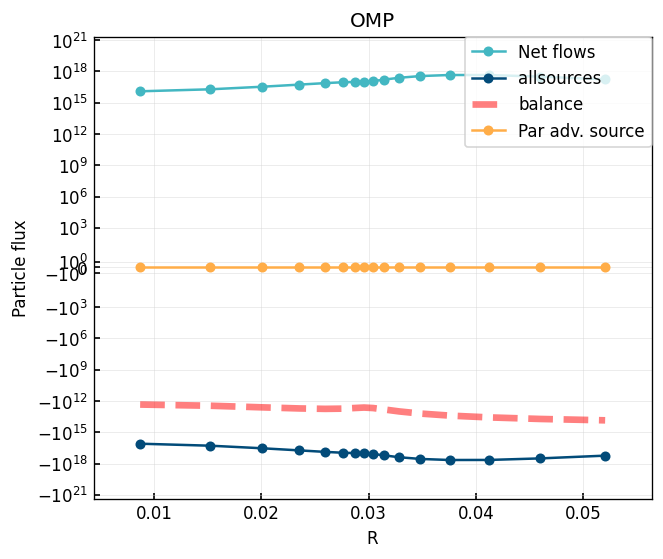

In [21]:
# reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))
reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2))
title = "OMP"

fig, ax = plt.subplots()
x = np.cumsum(reg["dr"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["pfNet"] + reg["pfSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
ax.set_yscale("symlog")
ax.set_xscale("linear")
# ax.set_xlim(0.8, None)

## Field line

(0.8, 1.028833172706219)

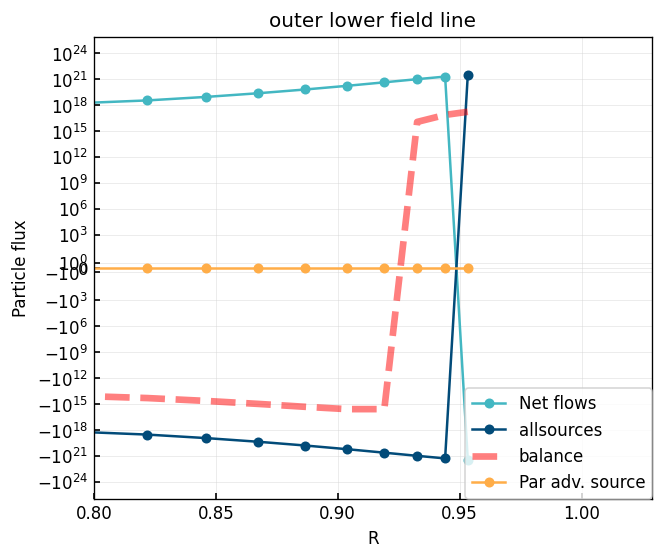

In [24]:
reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze()
title = "outer lower field line"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["pfNet"] + reg["pfSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_yscale("symlog")
ax.set_title(title)
ax.set_xlim(0.8, None)

## Target

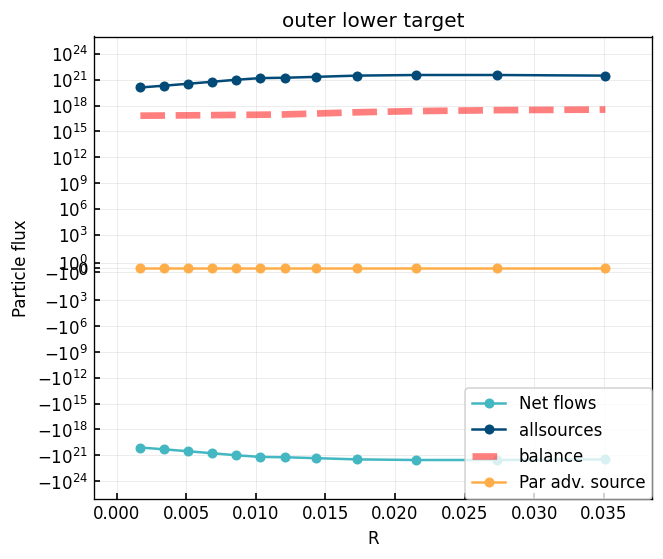

In [26]:
# reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))
reg = ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2))
title = "outer lower target"

fig, ax = plt.subplots()
x = np.cumsum(reg["dr"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["pfNet"] + reg["pfSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
ax.set_yscale("symlog")
ax.set_xscale("linear")
# ax.set_xlim(0.8, None)

# Energy vs. Pressure balances

## Core

In [7]:
cs.keys()

dict_keys(['alldisabled', 'newalldisabled', 'fix_dnnnn'])

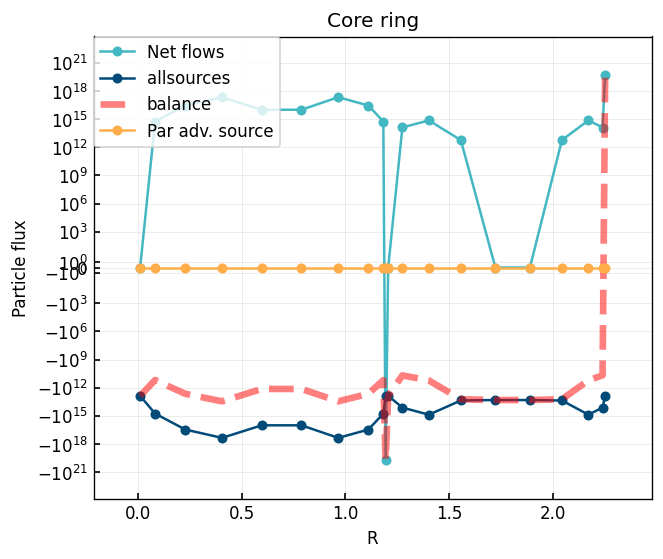

In [13]:
# reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))
# reg = ds.hermesm.select_region("outer_midplane_a").isel(x = slice(2,-2))
reg = ds.hermesm.select_region("core_edge").squeeze()
title = "Core ring"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["pfNet"] + reg["pfSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_yscale("symlog")
ax.set_ylabel("Particle flux")
ax.set_title(title)
ax.set_xscale("linear")

In [14]:
bal = reg["pfNet"] + reg["pfSrc"]
bal.values

array([-6.94096940e+12, -3.00428934e+11, -7.67724559e+12, -4.57351146e+13,
       -2.19693119e+12, -2.17898073e+12, -4.48027052e+13, -7.57710258e+12,
       -3.03150137e+11, -4.68326074e+19, -6.83517350e+12, -1.05393880e+11,
       -2.47797339e+11, -6.29528145e+10, -1.92306437e+13, -1.92834731e+13,
       -6.23330711e+10, -2.41887494e+11, -1.02183021e+11,  4.74500785e+19])

# 2D fields

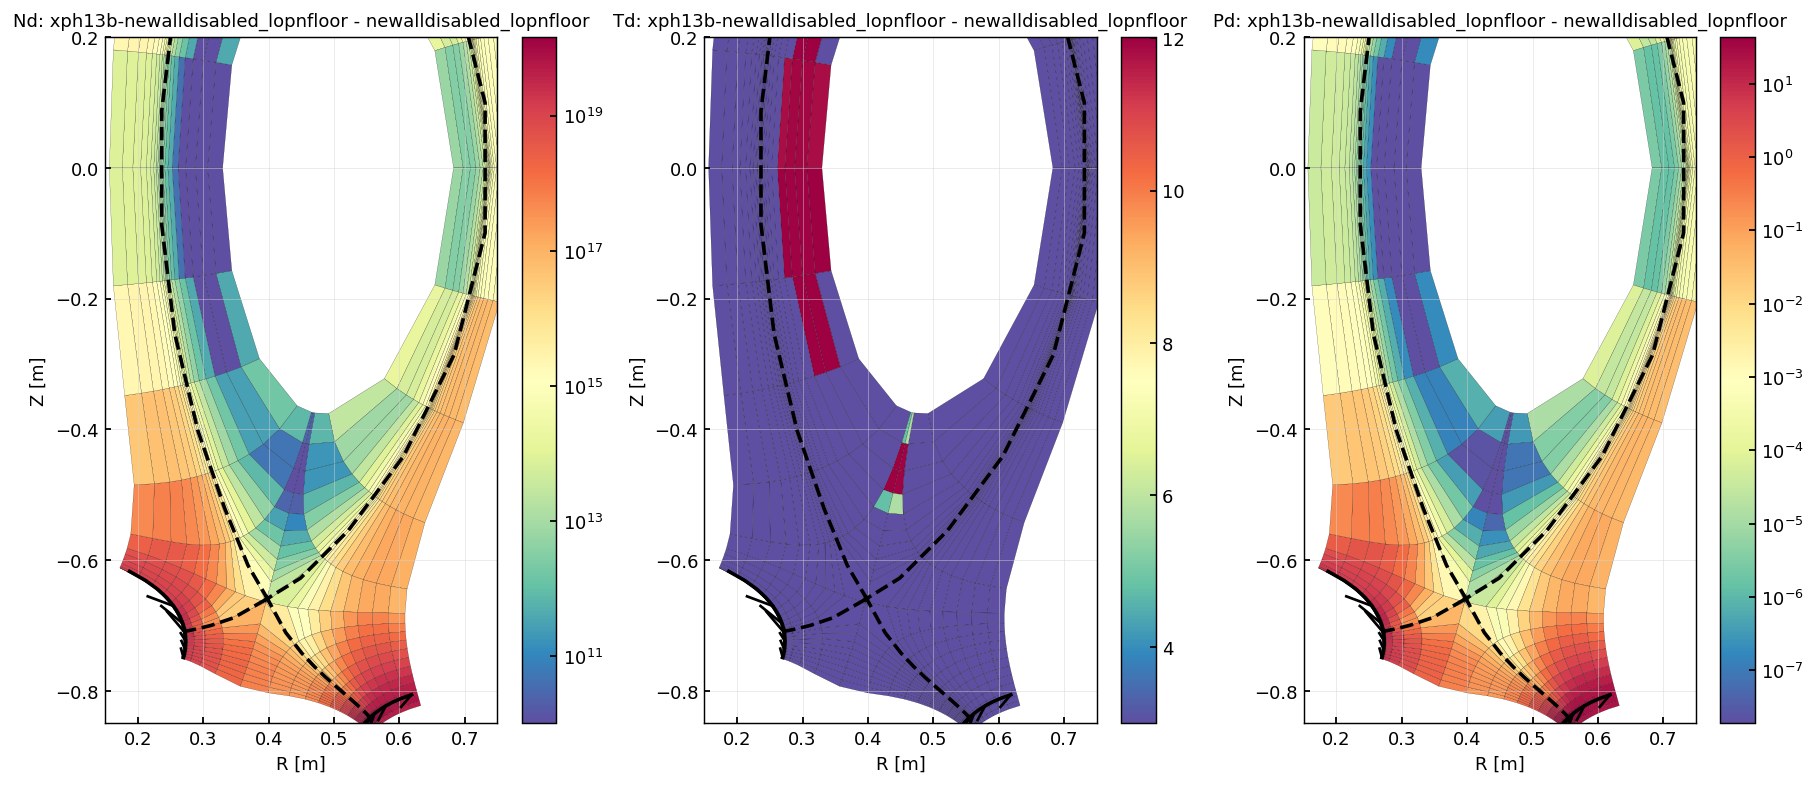

In [14]:
clean_guards = False

for entry in toload:
    case = entry["name"]
    fig, axes = plt.subplots(1,3, figsize = (14,6), dpi = 130)
    newds = cs[case].ds.isel(t=-1)
    
    ax = axes[0]
    data = (newds["Nd"])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True)
    ax.set_ylim(-0.85, 0.2)
    ax.set_xlim(0.15,0.75)
    ax.set_title(f"Nd: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[1]
    data = (newds["Td"])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = False)
    ax.set_ylim(-0.85, 0.2)
    ax.set_xlim(0.15,0.75)
    ax.set_title(f"Td: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[2]
    data = (newds["Pd"])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True)
    ax.set_ylim(-0.85, 0.2)
    ax.set_xlim(0.15,0.75)
    ax.set_title(f"Pd: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    fig.tight_layout()


# 2D balance

In [17]:
1e-10 *(1e17*100) # constants("q_e")

1000000000.0

In [19]:
100*1e17 * constants("q_e")

1.60217662

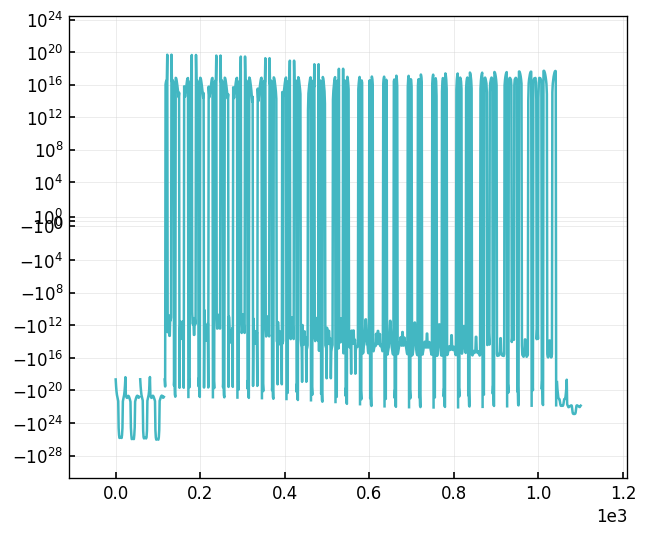

In [18]:
plt.plot(data.values.flatten())
plt.yscale("symlog")

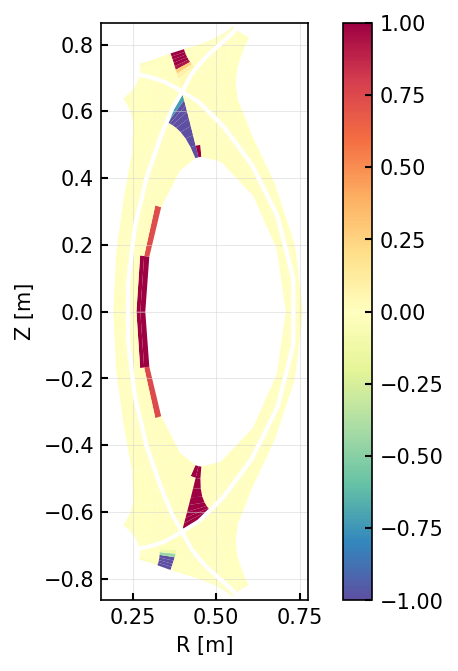

In [23]:
cmap = "Spectral_r"

fig, ax = plt.subplots(dpi = 150)

# data = ds["pfSrc"] + ds["pfNet"]
# data = ds["efSrc"] + ds["efNet"]
# data = ds["Sd_par_adv"] / ds["Sd_perp_adv"]
data = (ds["pfNet"] + ds["pfSrc"]) / ds["pfSrc"]
# data = (ds["efNet"] + ds["efSrc"]) / ds["efSrc"]
# data = ds["NVd"]
(data).hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                       antialias = True,
                                                       logscale = False,
                                                    #    vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                       vmin = -1, vmax = 1,
                                                       
                                                       )
# ax.set_ylim(-0.9, 0)


In [9]:
ds.hermesm.select_region("outer_midplane_a")["pfSrcFlowRatio"].values

array([            nan,            -inf, -5.42914293e+00,  1.91235222e+00,
        2.00280045e+00,  1.73069605e+00,  1.45552653e+00,  1.23447781e+00,
        1.09724077e+00,  1.10312612e+00,  1.20757751e+00,  1.51379410e+00,
        1.71442199e+00,  1.77475994e+00,  1.80399434e+00,  2.58432321e+00,
       -1.02624457e+00, -9.26297721e-02, -3.75014900e+04,            -inf])

In [15]:
np.nanmin(data.values)

-inf